In [51]:
# ============================== loading libraries ===========================================
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from prettytable import PrettyTable
import random
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import validation_curve
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score,roc_auc_score
from sklearn.preprocessing import StandardScaler

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

#import nltk
#nltk.download('stopwords')

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#from gensim.models import KeyedVectors
#model = KeyedVectors.load_word2vec_format(‘GoogleNews-vectors-negative300.bin.gz’,binary=True)

#import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
#filtered_data2 = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Id <= 10000""", con)
#taking into consideration only 10K entries because of memory contrain
filtered_data  = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
print(filtered_data.shape)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

# '0' represents negative and '1' represents positive
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)
# =============================================================================================

(525814, 10)
(525814, 10)


In [6]:
fileObject = open("./train_to_file2.pkl",'rb') # we open the file for reading 
X_train = pickle.load(fileObject) # load the object from the file

fileObject = open("./x_test_to_file2.pkl",'rb') # we open the file for reading 
X_test = pickle.load(fileObject) # load the object from the file

fileObject = open("./y_train_to_file2.pkl",'rb') # we open the file for reading 
y_train = pickle.load(fileObject) # load the object from the file

fileObject = open("./y_test_to_file2.pkl",'rb') # we open the file for reading 
y_test = pickle.load(fileObject) # load the object from the file

In [102]:
#Appling BoW to fit and transform
count_vect =  CountVectorizer()
bow_NB = count_vect.fit(X_train[:,9])
train_bow_nstd = count_vect.transform(X_train[:,9])
test_bow_nstd = count_vect.transform(X_test[:,9]) 

print("the type of count vectorizer ",type(train_bow_nstd))
print("the number of unique words ", test_bow_nstd.get_shape()[1])

print(train_bow_nstd.shape)
print(test_bow_nstd.shape)
print(y_test.shape)
print(y_train.shape)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words  50781
(70000, 50781)
(30000, 50781)
(30000,)
(70000,)


In [54]:
# Colum Standardization of the BoW non-standard vector
std_scal = StandardScaler(with_mean=False)
std_scal.fit(train_bow_nstd)
train_bow = std_scal.transform(train_bow_nstd)
test_bow = std_scal.transform(test_bow_nstd)

In [55]:
#Applying Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(train_bow, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
#Predicting over Test data points
pred_test = clf.predict(test_bow)
print(pred_test)

[1 1 0 ... 1 1 1]


In [100]:
# evaluating Grid Search
alphas = np.array([1,0.1,0.01,0.001,0.0001,0, 10, 100, 1000])
scorers = {'recall_score': make_scorer(roc_auc_score)}
grid = GridSearchCV(estimator=clf,
                  param_grid=dict(alpha=alphas),
                  scoring= scorers  , cv=5, refit='recall_score', return_train_score=True)
grid.fit(train_bow, y_train)
print(grid)
results = grid.cv_results_

# summarize the results of the grid search
print("\nBest score: ",grid.best_score_)
NB_OPTIMAL_clf = grid.best_estimator_
best_alpha_bow = grid.best_estimator_.alpha
print("Optimal value of Hyperparameter: ",best_alpha_bow)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00, 1.e+01, 1.e+02,
       1.e+03])},
       pre_dispatch='2*n_jobs', refit='recall_score',
       return_train_score=True,
       scoring={'recall_score': make_scorer(roc_auc_score)}, verbose=0)

Best score:  0.7083243936683615
Optimal value of Hyperparameter:  10.0


In [138]:
results

{'mean_fit_time': array([0.33619695, 0.32439642, 0.32360644, 0.33560047, 0.32840424,
        0.32299218, 0.317592  , 0.33820109, 0.32019854]),
 'std_fit_time': array([0.01696199, 0.00739405, 0.00733281, 0.01738931, 0.01531514,
        0.0014105 , 0.00161728, 0.01002463, 0.00147766]),
 'mean_score_time': array([0.03159823, 0.03059883, 0.030791  , 0.03040318, 0.0295958 ,
        0.03020616, 0.03060303, 0.03439546, 0.02959666]),
 'std_score_time': array([0.00174727, 0.00186037, 0.00117728, 0.00049302, 0.00048618,
        0.00075215, 0.00102061, 0.00484303, 0.00048303]),
 'param_alpha': masked_array(data=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.0, 10.0, 100.0,
                    1000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1.0},
  {'alpha': 0.1},
  {'alpha': 0.01},
  {'alpha': 0.001},
  {'alpha': 0.0001},
  {'alpha': 0.0},
  {'alpha': 10.0},
  {'alpha': 10

[0.00373627 0.00357732 0.00290678 0.00241937 0.00173401 0.00256286
 0.00362196 0.00517749 0.00554052]
[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 0.e+00 1.e+01 1.e+02 1.e+03]


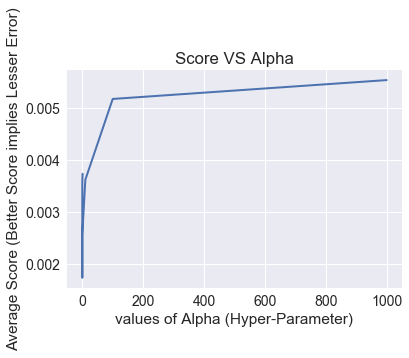

In [154]:
#Cross Validation scores of Test data
y_cord = results['std_test_recall_score']
x_cord = alphas
print(y_cord)
print(x_cord)

plt.plot(x_cord, y_cord, linewidth=2.0)
plt.title('Score VS Alpha')
plt.xlabel('values of Alpha (Hyper-Parameter)')
plt.ylabel('Average Score (Better Score implies Lesser Error)')
plt.show()

[0.00161394 0.00133157 0.00126168 0.00124901 0.00123736 0.00124293
 0.00181836 0.00136626 0.00135705]
[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 0.e+00 1.e+01 1.e+02 1.e+03]


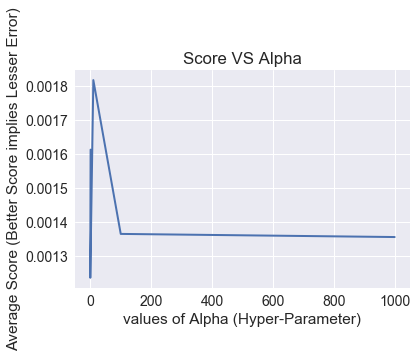

In [155]:
#Cross Validation scores of Train data
y_cord = results['std_train_recall_score']
x_cord = alphas
print(y_cord)
print(x_cord)

plt.plot(x_cord, y_cord, linewidth=2.0)
plt.title('Score VS Alpha')
plt.xlabel('values of Alpha (Hyper-Parameter)')
plt.ylabel('Average Score (Better Score implies Lesser Error)')
plt.show()

In [63]:
#Applying Multinomial Naive Bayes for Optimal Value of K=0.1
clf = MultinomialNB(0.1)
clf.fit(train_bow, y_train)

#Predicting over Train data points
pred_train = clf.predict(train_bow)
print(pred_train)

#Predicting over Test data points
pred_test = clf.predict(test_bow)
print(pred_test)

[0 1 1 ... 1 0 1]
[1 1 0 ... 1 1 1]


In [64]:
#Confusion matrix of Train Data
results_train = confusion_matrix(pred_train, y_train)
print(results_train)

[[ 7765  5176]
 [  793 56266]]


In [65]:
#Confusion matrix of Test Data
results_test = confusion_matrix(y_test, pred_test)
print(results_test)

[[ 2078  1634]
 [ 3196 23092]]


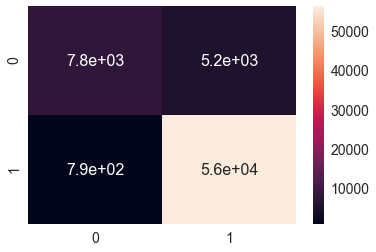

In [66]:
#plotting confusion matrix for Train Data
df_cm = pd.DataFrame(results_train, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

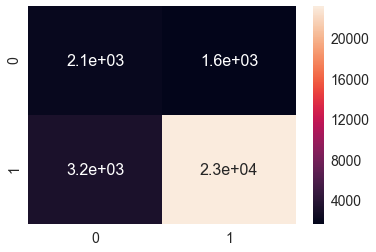

In [67]:
#plotting confusion matrix for Test Data
df_cm = pd.DataFrame(results_test, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [68]:
#Recall and Precision over Test data with confusion matrix
recall_test = np.diag(results_test) / np.sum(results_test, axis = 1)
precision_test = np.diag(results_test) / np.sum(results_test, axis = 0)
print(recall_test)
print(precision_test)

#F1 Score over Test data with Micro metric
f1_score_test = f1_score(y_test, pred_test, average='micro') 
print("F1-Score: ",f1_score_test)

[0.55980603 0.87842362]
[0.39400834 0.93391572]
F1-Score:  0.839


In [69]:
#Precision, recall, F1 Score for Test Data with funtion
a = precision_recall_fscore_support(y_test, pred_test, average='micro')
b = np.asarray(a)
precision_test,recall_test,f1_score_test,support = b.ravel()
#The support is the number of occurrences of each class in y_cv

print(precision_test)
print(recall_test)
print("F1-Score: ",f1_score_test)
print(support)

0.839
0.839
F1-Score:  0.839
None


In [70]:
print ('Report over Test Data: ')
print (classification_report(y_test, pred_test) )

Report over Test Data: 
             precision    recall  f1-score   support

          0       0.39      0.56      0.46      3712
          1       0.93      0.88      0.91     26288

avg / total       0.87      0.84      0.85     30000



In [105]:
#Get top 50 features displayed from both the negative and the positive review classes
    
neg_class_prob_sorted = (-NB_OPTIMAL_clf.feature_log_prob_[0, :]).argsort()              
pos_class_prob_sorted = (-NB_OPTIMAL_clf.feature_log_prob_[1, :]).argsort()
#Note : Putting a - sign indicates the indexes will be sorted in descending order.
    
neg_class_features = np.take(bow_NB.get_feature_names(), neg_class_prob_sorted[:50])
pos_class_features = np.take(bow_NB.get_feature_names(), pos_class_prob_sorted[:50])
    
print("The top 50 most frequent words from the positive class are :\n")
print(pos_class_features)
    
print("\nThe top 50 most frequent words from the negative class are :\n")
print(neg_class_features)
    
del(neg_class_prob_sorted, pos_class_prob_sorted, neg_class_features, pos_class_features)

The top 50 most frequent words from the positive class are :

['and' 'this' 'it' 'is' 'the' 'to' 'for' 'my' 'in' 'of' 'have' 'but'
 'with' 'great' 'are' 'good' 'so' 'on' 'that' 'you' 'not' 'like' 'they'
 'these' 'as' 'very' 'can' 'at' 'just' 'love' 'was' 'be' 'them' 'one'
 'taste' 'all' 'or' 'if' 'when' 'best' 'has' 'flavor' 'than' 'product'
 'more' 'from' 'will' 'other' 'get' 'find']

The top 50 most frequent words from the negative class are :

['not' 'this' 'the' 'was' 'to' 'but' 'and' 'it' 'of' 'is' 'that' 'in'
 'for' 'like' 'product' 'had' 'have' 'be' 'taste' 'would' 'they' 'my'
 'were' 'from' 'on' 'with' 'if' 'what' 'one' 'all' 'so' 'disappointed'
 'at' 'bad' 'money' 'just' 'there' 'very' 'again' 'no' 'did' 'even' 'are'
 'out' 'as' 'me' 'you' 'don' 'these' 'buy']


In [106]:
#True/False - Positives/Neagatives over Test Data

TN, FP, FN, TP = confusion_matrix(y_test, pred_test).ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR_bow = TP/(TP+FN)
# Specificity or true negative rate
TNR_bow = TN/(TN+FP) 
# Precision or positive predictive value
PPV_bow = TP/(TP+FP)
# Negative predictive value
NPV_bow = TN/(TN+FN)
# Fall out or false positive rate
FPR_bow = FP/(FP+TN)
# False negative rate
FNR_bow = FN/(TP+FN)
# False discovery rate
FDR_bow = FP/(TP+FP)
# Overall accuracy
ACC_bow = (TP+TN)/(TP+FP+FN+TN)

print(TPR_bow)
print(TNR_bow)
print(PPV_bow)
print(NPV_bow)
print(FPR_bow)
print(FNR_bow)
print(FDR_bow)
print(ACC_bow)

0.8784236153377967
0.5598060344827587
0.9339157162501011
0.3940083428138036
0.4401939655172414
0.12157638466220329
0.06608428374989889
0.839


In [108]:
#tf-idf on cross validation data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1)) #considering only uni-gram 
tfidf_NB = tf_idf_vect.fit(X_train[:,9])
train_tfidf_nstd = count_vect.transform(X_train[:,9])
test_tfidf_nstd = count_vect.transform(X_test[:,9]) 

print("the type of count vectorizer ",type(train_tfidf))
print("the number of unique words ", test_tfidf.get_shape()[1])

print(train_tfidf_nstd.shape)
print(test_tfidf_nstd.shape)
print(y_test.shape)
print(y_train.shape)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words  50781
(70000, 50781)
(30000, 50781)
(30000,)
(70000,)


In [113]:
# Colum Standardization of the tfidf non-standard vector
std_scal_tfidf = StandardScaler(with_mean=False)
std_scal_tfidf.fit(train_tfidf_nstd)
train_tfidf = std_scal_tfidf.transform(train_tfidf_nstd)
test_tfidf = std_scal_tfidf.transform(test_tfidf_nstd)

In [114]:
#Applying Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [115]:
#Predicting over Test data points
pred_test_tfidf = clf.predict(test_tfidf)
print(pred_test_tfidf)
print(train_tfidf.shape)

[1 1 0 ... 1 1 1]
(70000, 50781)


In [158]:
# evaluating Grid Search
alphas = np.array([1,0.1,0.01,0.001,0.0001,0, 10, 100, 1000])
scorers = {'recall_score': make_scorer(roc_auc_score)}
grid = GridSearchCV(estimator=clf,
                  param_grid=dict(alpha=alphas),
                  scoring= scorers  , cv=5, refit='recall_score', return_train_score=True)
grid.fit(train_bow, y_train)
print(grid)
results_tfidf = grid.cv_results_

# summarize the results of the grid search
print("\nBest score: ",grid.best_score_)
NB_OPTIMAL_clf_tfidf = grid.best_estimator_
best_alpha_tfidf = grid.best_estimator_.alpha
print("Optimal value of Hyperparameter: ",best_alpha_tfidf)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00, 1.e+01, 1.e+02,
       1.e+03])},
       pre_dispatch='2*n_jobs', refit='recall_score',
       return_train_score=True,
       scoring={'recall_score': make_scorer(roc_auc_score)}, verbose=0)

Best score:  0.7083243936683615
Optimal value of Hyperparameter:  10.0


In [159]:
results_tfidf

{'mean_fit_time': array([0.33959942, 0.33540196, 0.32899709, 0.33179622, 0.38819637,
        0.36579752, 0.37499948, 0.39039831, 0.36179843]),
 'std_fit_time': array([0.01153274, 0.01620168, 0.00268531, 0.0059193 , 0.04779915,
        0.02998345, 0.0458229 , 0.04196867, 0.02224801]),
 'mean_score_time': array([0.03140359, 0.03059878, 0.03040709, 0.03259978, 0.03699255,
        0.03580189, 0.03679152, 0.03819866, 0.03239765]),
 'std_score_time': array([0.0014929 , 0.00079691, 0.00101902, 0.00307578, 0.00666774,
        0.00573752, 0.00553498, 0.0086548 , 0.00162815]),
 'param_alpha': masked_array(data=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.0, 10.0, 100.0,
                    1000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1.0},
  {'alpha': 0.1},
  {'alpha': 0.01},
  {'alpha': 0.001},
  {'alpha': 0.0001},
  {'alpha': 0.0},
  {'alpha': 10.0},
  {'alpha': 10

[0.00373627 0.00357732 0.00290678 0.00241937 0.00173401 0.00256286
 0.00362196 0.00517749 0.00554052]
[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 0.e+00 1.e+01 1.e+02 1.e+03]


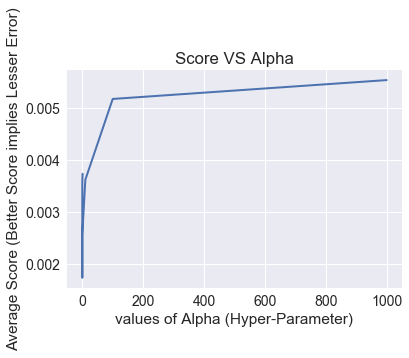

In [160]:
#Cross Validation scores of Test data
y_cord = results_tfidf['std_test_recall_score']
x_cord = alphas
print(y_cord)
print(x_cord)

plt.plot(x_cord, y_cord, linewidth=2.0)
plt.title('Score VS Alpha')
plt.xlabel('values of Alpha (Hyper-Parameter)')
plt.ylabel('Average Score (Better Score implies Lesser Error)')
plt.show()

[0.00161394 0.00133157 0.00126168 0.00124901 0.00123736 0.00124293
 0.00181836 0.00136626 0.00135705]
[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 0.e+00 1.e+01 1.e+02 1.e+03]


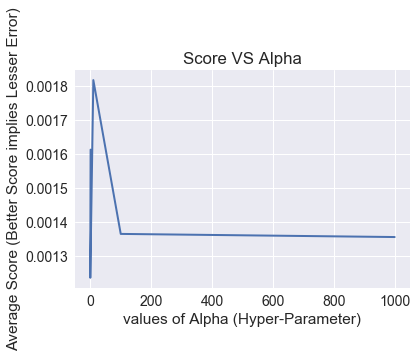

In [161]:
#Cross Validation scores of Train data
y_cord = results_tfidf['std_train_recall_score']
x_cord = alphas
print(y_cord)
print(x_cord)

plt.plot(x_cord, y_cord, linewidth=2.0)
plt.title('Score VS Alpha')
plt.xlabel('values of Alpha (Hyper-Parameter)')
plt.ylabel('Average Score (Better Score implies Lesser Error)')
plt.show()

In [120]:
#Applying Multinomial Naive Bayes for Optimal Value of K=0.1
clf_tfidf = MultinomialNB(0.1)
clf_tfidf.fit(train_tfidf, y_train)

#Predicting over Train data points
pred_train_tfidf = clf.predict(train_tfidf)
print(pred_train)

#Predicting over Test data points
pred_test_tfidf = clf_tfidf.predict(test_tfidf)
print(pred_test_tfidf)
print(pred_test_tfidf.shape)

[0 1 1 ... 1 0 1]
[1 1 0 ... 1 1 1]
(30000,)


In [121]:
#Confusion matrix of Train Data
results_train_tfidf = confusion_matrix(pred_train_tfidf, y_train)
print(results_train)

[[ 7765  5176]
 [  793 56266]]


In [122]:
#Confusion matrix of Test Data
results_test_tfidf = confusion_matrix(y_test, pred_test_tfidf)
print(results_test_tfidf)

[[ 2078  1634]
 [ 3196 23092]]


In [123]:
print ('Report : ')
print (classification_report(y_train, pred_train_tfidf) )

Report : 
             precision    recall  f1-score   support

          0       0.60      0.91      0.72      8558
          1       0.99      0.92      0.95     61442

avg / total       0.94      0.91      0.92     70000



In [124]:
print ('Report : ')
print (classification_report(y_test, pred_test_tfidf) )

Report : 
             precision    recall  f1-score   support

          0       0.39      0.56      0.46      3712
          1       0.93      0.88      0.91     26288

avg / total       0.87      0.84      0.85     30000



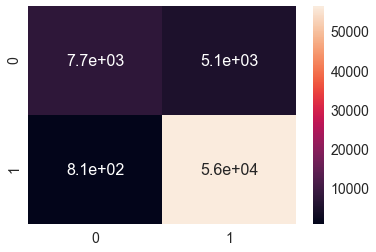

In [125]:
#plotting confusion matrix for Train Data
df_cm = pd.DataFrame(results_train_tfidf, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

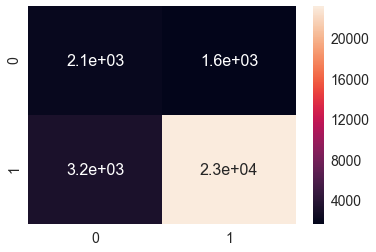

In [126]:
#plotting confusion matrix for Test Data
df_cm = pd.DataFrame(results_test_tfidf, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [128]:
#Recall and Precision over Test data with confusion matrix
recall_test_tfidf = np.diag(results_test_tfidf) / np.sum(results_test_tfidf, axis = 1)
precision_test_tfidf = np.diag(results_test_tfidf) / np.sum(results_test_tfidf, axis = 0)
print(recall_test_tfidf)
print(precision_test_tfidf)

#F1 Score over Test data with Micro metric
f1_score_test_tfidf = f1_score(y_test, pred_test_tfidf, average='micro') 
print("F1-Score: ",f1_score_test_tfidf)

[0.55980603 0.87842362]
[0.39400834 0.93391572]
F1-Score:  0.839


In [129]:
#Precision, recall, F1 Score for Test Data with funtion
a = precision_recall_fscore_support(y_test, pred_test_tfidf, average='micro')
b = np.asarray(a)
precision_test_tfidf,recall_test_tfidf,f1_score_test_tfidf,support = b.ravel()
#The support is the number of occurrences of each class in y_cv

print(precision_test_tfidf)
print(recall_test_tfidf)
print("F1-Score: ",f1_score_test_tfidf)
print(support)

0.839
0.839
F1-Score:  0.839
None


In [133]:
#Get top 50 features displayed from both the negative and the positive review classes
    
neg_class_prob_sorted = (-NB_OPTIMAL_clf_tfidf.feature_log_prob_[0, :]).argsort()              
pos_class_prob_sorted = (-NB_OPTIMAL_clf_tfidf.feature_log_prob_[1, :]).argsort()
#Note : Putting a - sign indicates the indexes will be sorted in descending order.
    
neg_class_features = np.take(tfidf_NB.get_feature_names(), neg_class_prob_sorted[:50])
pos_class_features = np.take(tfidf_NB.get_feature_names(), pos_class_prob_sorted[:50])
    
print("The top 50 most frequent words from the positive class are :\n")
print(pos_class_features)
    
print("\nThe top 50 most frequent words from the negative class are :\n")
print(neg_class_features)
    
del(neg_class_prob_sorted, pos_class_prob_sorted, neg_class_features, pos_class_features)

The top 50 most frequent words from the positive class are :

['and' 'this' 'it' 'is' 'the' 'to' 'for' 'my' 'in' 'of' 'have' 'but'
 'with' 'great' 'are' 'good' 'so' 'on' 'that' 'you' 'not' 'like' 'they'
 'these' 'as' 'very' 'can' 'at' 'just' 'love' 'was' 'be' 'them' 'one'
 'taste' 'all' 'or' 'if' 'when' 'best' 'has' 'flavor' 'than' 'product'
 'more' 'from' 'will' 'other' 'get' 'find']

The top 50 most frequent words from the negative class are :

['not' 'this' 'the' 'was' 'to' 'but' 'and' 'it' 'of' 'is' 'that' 'in'
 'for' 'like' 'product' 'had' 'have' 'be' 'taste' 'would' 'they' 'my'
 'were' 'from' 'on' 'with' 'if' 'what' 'one' 'all' 'so' 'disappointed'
 'at' 'bad' 'money' 'just' 'there' 'very' 'again' 'no' 'did' 'even' 'are'
 'out' 'as' 'me' 'you' 'don' 'these' 'buy']


In [134]:
#True/False - Positives/Neagatives over Test Data

TN, FP, FN, TP = confusion_matrix(y_test, pred_test_tfidf).ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR_tfidf = TP/(TP+FN)
# Specificity or true negative rate
TNR_tfidf = TN/(TN+FP) 
# Precision or positive predictive value
PPV_tfidf = TP/(TP+FP)
# Negative predictive value
NPV_tfidf = TN/(TN+FN)
# Fall out or false positive rate
FPR_tfidf = FP/(FP+TN)
# False negative rate
FNR_tfidf = FN/(TP+FN)
# False discovery rate
FDR_tfidf = FP/(TP+FP)
# Overall accuracy
ACC_tfidf = (TP+TN)/(TP+FP+FN+TN)

print(TPR_tfidf)
print(TNR_tfidf)
print(PPV_tfidf)
print(NPV_tfidf)
print(FPR_tfidf)
print(FNR_tfidf)
print(FDR_tfidf)
print(ACC_tfidf)

0.8784236153377967
0.5598060344827587
0.9339157162501011
0.3940083428138036
0.4401939655172414
0.12157638466220329
0.06608428374989889
0.839


In [135]:
x = PrettyTable()
x.field_names = ["Paramters/Models","BoW", "TF-IDF"]

x.add_row(["Hyperparameter", best_alpha_bow, best_alpha_tfidf])
x.add_row(["Recall (Test_Data)", recall_test, recall_test_tfidf])
x.add_row(["Precision (Test_Data)", precision_test, precision_test_tfidf])
x.add_row(["F1-Score (Test_Data)", f1_score_test, f1_score_test_tfidf])

x.add_row(["TPR ", TPR_bow, TPR_tfidf])
x.add_row(["TNR ", TNR_bow, TNR_tfidf])
x.add_row(["FPR ", FPR_bow, FPR_tfidf])
x.add_row(["FNR ", FNR_bow, FNR_tfidf])

print(x)

+-----------------------+---------------------+---------------------+
|    Paramters/Models   |         BoW         |        TF-IDF       |
+-----------------------+---------------------+---------------------+
|     Hyperparameter    |         10.0        |         10.0        |
|   Recall (Test_Data)  |        0.839        |        0.839        |
| Precision (Test_Data) |        0.839        |        0.839        |
|  F1-Score (Test_Data) |        0.839        |        0.839        |
|          TPR          |  0.8784236153377967 |  0.8784236153377967 |
|          TNR          |  0.5598060344827587 |  0.5598060344827587 |
|          FPR          |  0.4401939655172414 |  0.4401939655172414 |
|          FNR          | 0.12157638466220329 | 0.12157638466220329 |
+-----------------------+---------------------+---------------------+


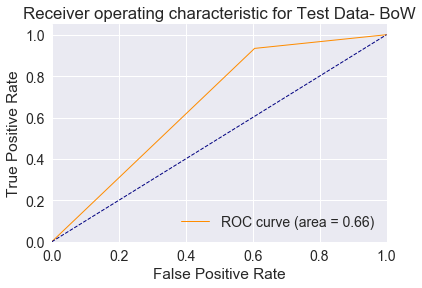

In [136]:
fpr, tpr, thresholds = roc_curve(pred_test, y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Test Data- BoW')
plt.legend(loc="lower right")
plt.show()

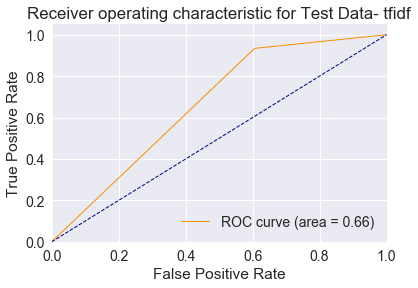

In [137]:
fpr, tpr, thresholds = roc_curve(pred_test_tfidf, y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Test Data- tfidf')
plt.legend(loc="lower right")
plt.show()